## Import modules

In [22]:
import pdb
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
import nhanes as nhanes

%matplotlib notebook

import importlib
importlib.reload(nhanes)

<module 'nhanes' from '/Users/qiwenlyu/Development/health/Health-Analytics-Opportunistic/nhanes.py'>

## Settings

In [2]:
DATA_PATH = '/Users/qiwenlyu/Development/health/NHANES/'
DATASET = 'arthritis'

### Note: 
The code below loads each dataset: dataset_features, dataset_targets

Here, all datasets are defined explicitly (see nhanes.py).

In [36]:
importlib.reload(nhanes)
ds = nhanes.Dataset(DATA_PATH)
ds.load_arthritis()
n_fe = ds.features.shape[1]
n_classes = 2

indx = np.argwhere(ds.targets != 3)
dataset_features = ds.features[indx.flatten()]
dataset_targets = ds.targets[indx.flatten()]

[<nhanes.FeatureColumn object at 0x1a25d02a20>, <nhanes.FeatureColumn object at 0x1a25e23b38>, <nhanes.FeatureColumn object at 0x1a25e23898>, <nhanes.FeatureColumn object at 0x1a25b23860>, <nhanes.FeatureColumn object at 0x1a25b01f60>, <nhanes.FeatureColumn object at 0x1a27ddc0b8>, <nhanes.FeatureColumn object at 0x1a27ddc1d0>, <nhanes.FeatureColumn object at 0x1a27ddc080>, <nhanes.FeatureColumn object at 0x1a27dc14e0>, <nhanes.FeatureColumn object at 0x1a27dc1b38>, <nhanes.FeatureColumn object at 0x1a27dc1c18>, <nhanes.FeatureColumn object at 0x1a27dc1fd0>, <nhanes.FeatureColumn object at 0x1a27dc1438>, <nhanes.FeatureColumn object at 0x1a27dc19b0>, <nhanes.FeatureColumn object at 0x1a27dc1c50>, <nhanes.FeatureColumn object at 0x1a27dc1518>, <nhanes.FeatureColumn object at 0x1a27dc1a90>, <nhanes.FeatureColumn object at 0x1a27dc1e80>, <nhanes.FeatureColumn object at 0x1a27dc17b8>, <nhanes.FeatureColumn object at 0x1a27dc15f8>, <nhanes.FeatureColumn object at 0x1a27dc12e8>, <nhanes.Feat

## Train/Test Separation

In [26]:
#mutual information part
mutualInfo = mutual_info_classif(dataset_features,dataset_targets)
dataset_features = dataset_features.T[mutualInfo > 0].T
print(dataset_features.shape)
perm = np.random.permutation(dataset_targets.shape[0])
dataset_features = dataset_features[perm]
dataset_targets = dataset_targets[perm]

def get_batch(n_size, phase):
    # select indices
    n_samples = dataset_features.shape[0]
    n_classes = int(dataset_targets.max() + 1)
    if phase == 'test':
        inds_sel = np.arange(0, int(n_samples*0.15), 1)
    elif phase == 'validation':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.15), int(n_samples*0.30), 1)
    elif phase == 'train':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.30), n_samples, 1)
    else:
        raise NotImplementedError
    inds_sel = np.random.permutation(inds_sel)
    batch_inds = []
    for cl in range(n_classes):
        inds_cl = inds_sel[dataset_targets[inds_sel] == cl]
        batch_inds.extend(inds_cl[:n_size//n_classes])
    batch_inds = np.random.permutation(batch_inds)
    
    return dataset_features[batch_inds], dataset_targets[batch_inds]
    
features_trn, targets_trn = get_batch(n_size=5000, phase='train')
features_tst, targets_tst = get_batch(n_size=1000, phase='test')

(5719, 128)


## Classification

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Feature Selection using Univariate selection

In [39]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#We will select the features using chi square

test = SelectKBest(score_func=chi2, k=4)

#Fit the function for ranking the features by score

fit = test.fit(features_trn, targets_trn)

#Summarize scores numpy.set_printoptions(precision=3) print(fit.scores_)

#Apply the transformation on to dataset

features = fit.transform(features_trn)

print(features)

ValueError: Input X must be non-negative.

## Feature Selection using Univariate selection

In [55]:
#neural network
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_RFC', accu)

accu_tst_RFC 0.8202054794520548


In [47]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_RFC', accu)

accu_tst_RFC 0.8544520547945206


In [48]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_RFC', accu)

accu_tst_RFC 0.8613013698630136


In [57]:
from sklearn import ensemble
from sklearn import datasets

original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 5}
clf = ensemble.GradientBoostingClassifier(**original_params)
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_RFC', accu)

accu_tst_RFC 0.8373287671232876


accu_tst_RFC 0.851027397260274
Confusion matrix, without normalization
[[  6  78]
 [  9 491]]


<IPython.core.display.Javascript object>


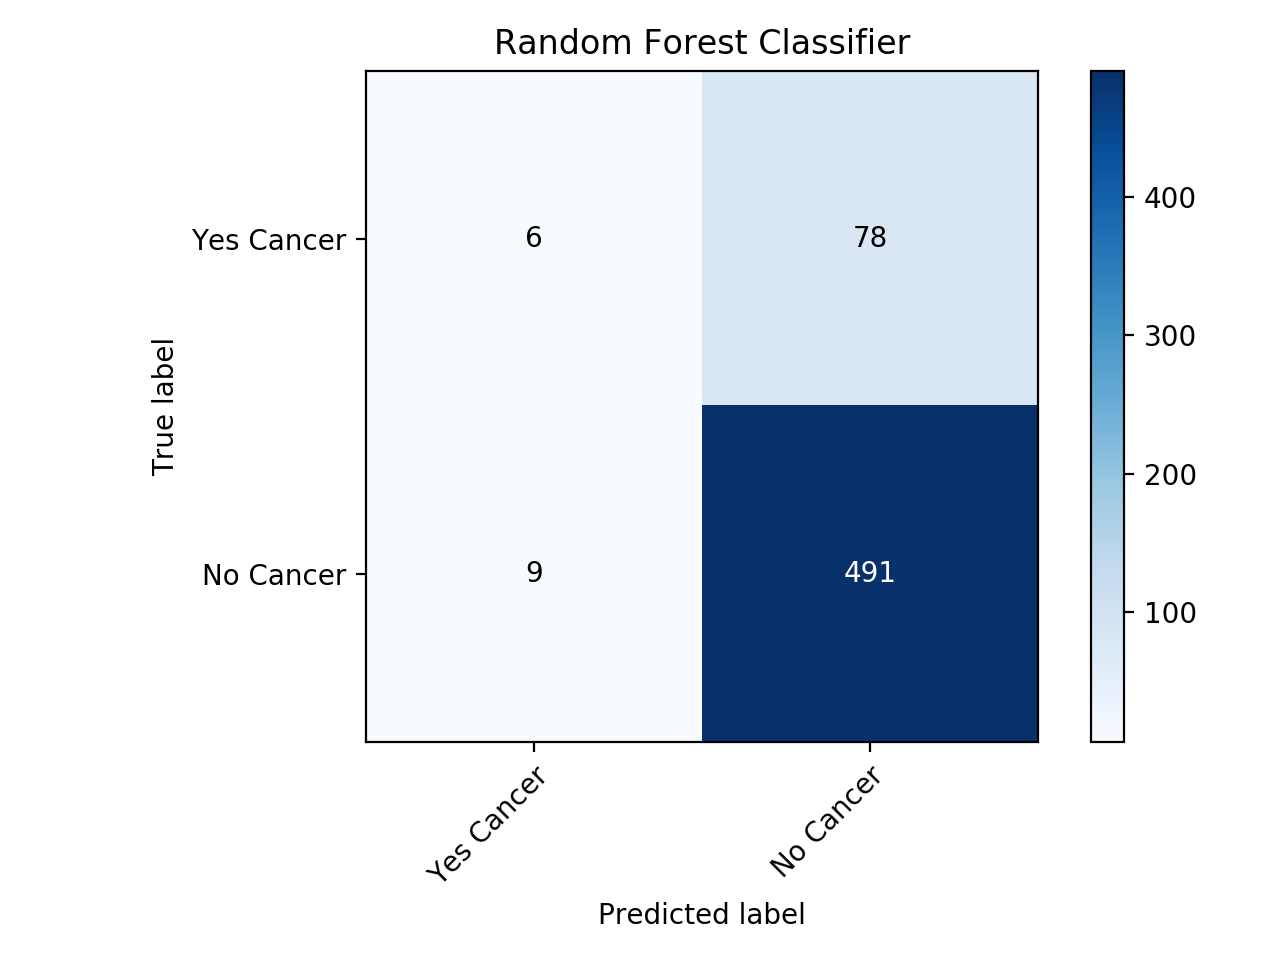

              precision    recall  f1-score   support

         0.0       0.40      0.07      0.12        84
         1.0       0.86      0.98      0.92       500

    accuracy                           0.85       584
   macro avg       0.63      0.53      0.52       584
weighted avg       0.80      0.85      0.80       584

accu_tst_SVC 0.738013698630137
Confusion matrix, without normalization
[[ 66  18]
 [135 365]]


<IPython.core.display.Javascript object>


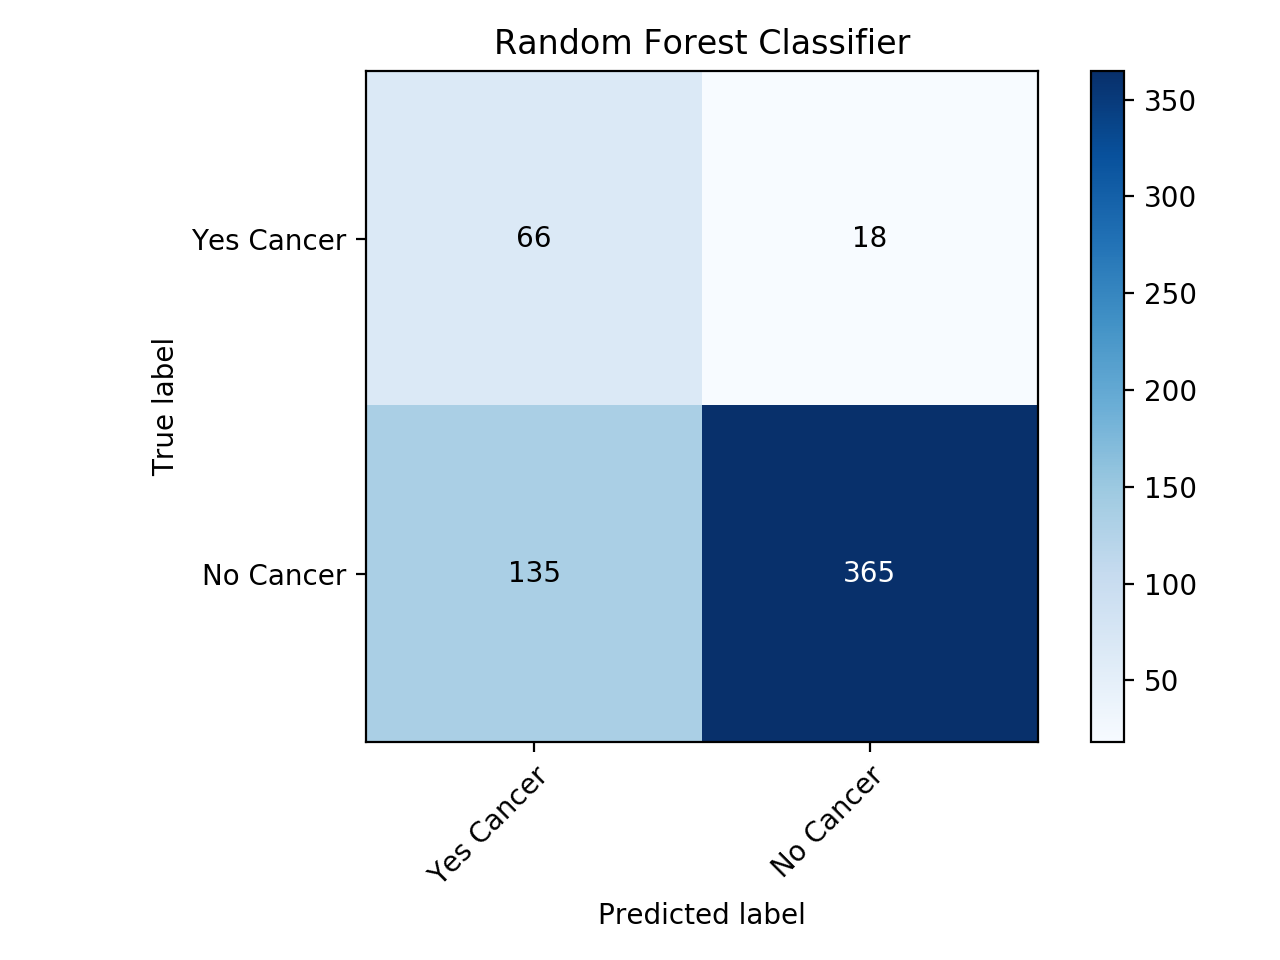

              precision    recall  f1-score   support

         0.0       0.33      0.79      0.46        84
         1.0       0.95      0.73      0.83       500

    accuracy                           0.74       584
   macro avg       0.64      0.76      0.64       584
weighted avg       0.86      0.74      0.77       584

accu_tst_LR 0.7157534246575342
Confusion matrix, without normalization
[[ 59  25]
 [141 359]]


/Users/qiwenlyu/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


<IPython.core.display.Javascript object>


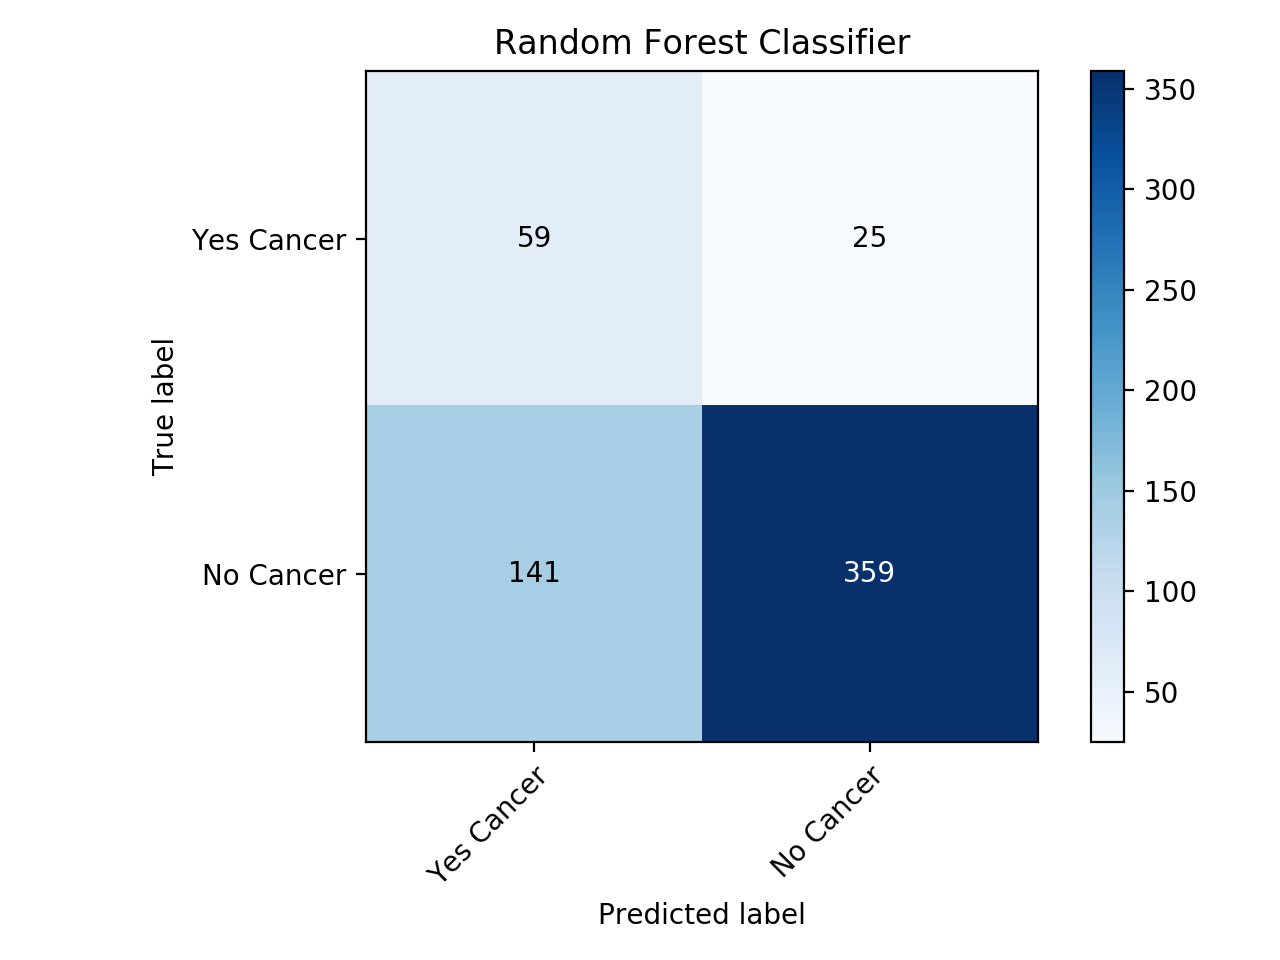

              precision    recall  f1-score   support

         0.0       0.29      0.70      0.42        84
         1.0       0.93      0.72      0.81       500

    accuracy                           0.72       584
   macro avg       0.61      0.71      0.61       584
weighted avg       0.84      0.72      0.76       584



In [59]:
from sklearn.metrics import confusion_matrix
clf = RandomForestClassifier(n_estimators=100,class_weight='balanced')
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_RFC', accu)
# Print the name and gini importance of each feature
#print(clf.feature_importances_)
#print(len(clf.feature_importances_))
#cm = confusion_matrix(targets_tst, preds_tst)
plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Cancer', 'No Cancer'],title='Random Forest Classifier')
print(classification_report(targets_tst, preds_tst))
#print(cm)

clf = SVC(gamma='auto',class_weight='balanced')
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_SVC', accu)
#cm = confusion_matrix(targets_tst, preds_tst)
plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Cancer', 'No Cancer'],title='Random Forest Classifier')
print(classification_report(targets_tst, preds_tst))
#print(cm)

clf = LogisticRegression(solver='lbfgs', max_iter=200,class_weight='balanced')
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_LR', accu)
#cm = confusion_matrix(targets_tst, preds_tst)
plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Cancer', 'No Cancer'],title='Random Forest Classifier')
print(classification_report(targets_tst, preds_tst))
#print(cm)



In [28]:
print(classification_report(targets_tst, preds_tst))

ValueError: Found input variables with inconsistent numbers of samples: [584, 585]